评估“是否给文章推送广告”对“文章阅读量”的因果影响。

但直接用“是否推送广告（treatment）”做回归可能有内生性问题（比如高质量内容更可能被推广告，也更受欢迎，导致估计偏差）。

工具变量：当天的广告投放预算是否较高（high_budget），影响是否推广告，但不直接影响文章阅读量。



In [2]:
# 数据可视化的库
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题
# 其它
import warnings
warnings.filterwarnings('ignore') #忽视警告

e:\Program Files\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt

np.random.seed(2025)
n = 600

# 工具变量：广告预算是否高 (1=高预算日, 0=普通日)
high_budget = np.random.binomial(1, 0.4, n)

# 一些其他潜在影响因素（影响是否推广告和阅读量的隐藏因素）
content_quality = np.random.normal(size=n)  # 内容质量，无法观测的因素

# 是否推送广告，受预算和内容质量影响
treatment = 0.7 * high_budget + 0.5 * content_quality + np.random.normal(scale=0.5, size=n)

# 阅读量（因变量），受广告推送和内容质量影响
# 真实广告推送影响为15，内容质量也影响阅读量（被遗漏，导致内生）
views = 100 + 15 * treatment + 10 * content_quality + np.random.normal(scale=5, size=n)

df = pd.DataFrame({
    'views': views,
    'treatment': treatment,
    'high_budget': high_budget
})


In [4]:

# OLS估计（忽略内生性）
X_ols = sm.add_constant(df['treatment'])
ols_model = sm.OLS(df['views'], X_ols).fit()

print("OLS结果：")
print(ols_model.summary())


OLS结果：
                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     2362.
Date:                Wed, 11 Jun 2025   Prob (F-statistic):          7.37e-210
Time:                        16:29:48   Log-Likelihood:                -2184.3
No. Observations:                 600   AIC:                             4373.
Df Residuals:                     598   BIC:                             4381.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         97.6428      0.403    242.247  

In [5]:
# IV估计
iv_model = IV2SLS(df['views'], sm.add_constant(df['treatment']), instrument=sm.add_constant(df['high_budget'])).fit()

print("\nIV2SLS结果：")
print(iv_model.summary())



IV2SLS结果：
                          IV2SLS Regression Results                           
Dep. Variable:                  views   R-squared:                       0.726
Model:                         IV2SLS   Adj. R-squared:                  0.725
Method:                     Two Stage   F-statistic:                     186.6
                        Least Squares   Prob (F-statistic):           3.64e-37
Date:                Wed, 11 Jun 2025                                         
Time:                        16:29:48                                         
No. Observations:                 600                                         
Df Residuals:                     598                                         
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.7238      0.564    176.7



## 1. OLS结果解读

* **模型**：使用普通最小二乘法（OLS）直接回归文章阅读量（views）对是否推广告（treatment）的影响。
* **关键系数**：treatment 的系数是 22.82，意味着广告推送会使阅读量平均增加约22.82。
* **统计显著性**：p值几乎为0（远小于0.05），说明这个效果非常显著。
* **R²=0.798**，说明模型能解释大约79.8%的阅读量波动，拟合度较高。

**注意**：OLS假设没有内生性问题，但这里可能存在“内容质量”等未被控制的混淆变量，导致广告推送系数被高估。

---

## 2. IV2SLS（工具变量法）结果解读

* **方法**：用“广告预算高低（high\_budget）”作为工具变量，解决treatment的内生性问题。
* **关键系数**：treatment 的系数降为约 15.95，比OLS结果低，说明剔除了偏误后的“真实”广告推送效应更小，但仍显著正向影响。
* **统计显著性**：p值远小于0.05，说明工具变量估计效果稳定可靠。
* **R²=0.726**，说明模型解释力稍弱于OLS，但更合理。

---

## 3. 总结

* OLS估计因为忽略了潜在混淆变量，导致广告推送的影响被高估（22.82 vs 15.95）。
* 工具变量法利用“广告预算高低”这一影响广告推送但不直接影响阅读量的外生变量，获得了较为可靠的因果效应估计。
* 结论是：**广告推送确实显著提升了文章阅读量，估计提升大约在16左右（而非22.8）。**


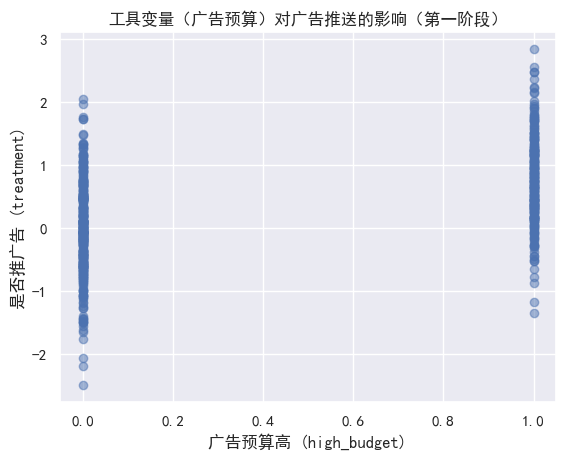

In [6]:

# 可视化广告预算和广告推送关系（第一阶段）
plt.scatter(df['high_budget'], df['treatment'], alpha=0.5)
plt.xlabel('广告预算高 (high_budget)')
plt.ylabel('是否推广告 (treatment)')
plt.title('工具变量（广告预算）对广告推送的影响（第一阶段）')
plt.show()
